# PPFL
(after HFL learning)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.dataset import Dataset

from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import shap

from PPFL import *

In [2]:
seed = 42
deterministic = True

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [42]:
client5 = pd.read_csv('./data/client5.csv')
X_5 = client5.drop('fraud_bool',axis=1)
y_5 = client5['fraud_bool']
columns = X_5.columns

test_under = pd.read_csv('./data/client_test_under.csv')
X_test_under = test_under.drop('fraud_bool',axis=1)
y_test_under = test_under['fraud_bool']

In [43]:
object_col = {'payment_type':{'AE':0, 'AD':1, 'AC':2, 'AA':3, 'AB':4},
                'employment_status':{'CE':0, 'CA':1, 'CB':2, 'CC':3, 'CG':4, 'CD':5, 'CF':6},
                'housing_status':{'BE':0, 'BF':1, 'BC':2, 'BG':3, 'BA':4, 'BD':5, 'BB':6},
                'source':{'INTERNET':0, 'TELEAPP':1},
                'device_os':{'other':0, 'windows':1, 'x11':2, 'linux':3, 'macintosh':4}}

for col,vals in object_col.items():
    X_5[col] = X_5[col].replace(vals)
    X_test_under[col] = X_test_under[col].replace(vals)

scaler = StandardScaler()
X_5 = scaler.fit_transform(X_5)
X_test_under = scaler.transform(X_test_under)


# model training

In [5]:
HFL_model = FL_net(input_dim=20)
VFL_model = FL_net(input_dim=11)

In [6]:
import pickle
with open('weight.pickle', 'rb') as f:
    weight = pickle.load(f)
for k,v in weight.items():
    k_replace = k.replace('module.','')
    HFL_model.state_dict()[k_replace].copy_(v)

In [7]:
common_idx = [2, 3, 4, 5, 6, 7, 12, 13, 14, 15, 17, 19, 20, 22, 23, 24, 25, 26, 28, 30]
specific_idx = [0, 1, 8, 9, 10, 11, 16, 18, 21, 27, 29]
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')

In [10]:
# HFL
y_5_predict = HFL_model(torch.Tensor(X_5[:,common_idx]))
y_5_predict = torch.argmax(y_5_predict, dim=1).cpu().detach().numpy()
print('HFL accuracy: ', accuracy_score(y_5, y_5_predict))
print('HFL f1 score: ', f1_score(y_5, y_5_predict))

HFL accuracy:  0.717940414507772
HFL f1 score:  0.713392563343205


In [12]:
# clinent5

DS5 = Dataset(torch.Tensor(X_5), torch.LongTensor(y_5.values))
DS_test = Dataset(torch.Tensor(X_test_under), torch.LongTensor(y_test_under.values))

client5_skorch = NeuralNetClassifier(
    FL_net(input_dim=31),
    max_epochs=100,
    lr=0.01,
    optimizer=torch.optim.SGD,
    optimizer__weight_decay=0.0004,
    batch_size=128,
    criterion=nn.CrossEntropyLoss,
    device=device,
    train_split=predefined_split(DS_test)
)
client5_skorch.fit(DS5,y=None)
print()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6893       0.5740        0.6895  0.7300
      2        0.6881       0.5952        0.6884  0.1058
      3        0.6869       0.6102        0.6872  0.1060
      4        0.6856       0.6233        0.6859  0.1056
      5        0.6843       0.6369        0.6846  0.1050
      6        0.6829       0.6469        0.6832  0.1050
      7        0.6813       0.6590        0.6816  0.1048
      8        0.6796       0.6676        0.6799  0.1120
      9        0.6778       0.6747        0.6781  0.1068
     10        0.6757       0.6836        0.6760  0.1069
     11        0.6734       0.6887        0.6736  0.1081
     12        0.6707       0.6910        0.6710  0.1057
     13        0.6678       0.6975        0.6680  0.1154
     14        0.6644       0.7037        0.6647  0.1081
     15        0.6607       0.7088        0.6610  0.1034
     16        0.6565       0.7

In [13]:
ppfl_net = PPFL_net(HFL_model, VFL_model, common_idx=common_idx, specific_idx=specific_idx, device=device)

ppfl_skorch = NeuralNetClassifier(
    ppfl_net,
    max_epochs=100,
    lr=0.01,
    optimizer=torch.optim.SGD,
    optimizer__weight_decay=0.0004,
    batch_size=128,
    criterion=nn.CrossEntropyLoss,
    device=device,
    train_split=predefined_split(DS_test)
)
ppfl_skorch.fit(DS5,y=None)
print()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6645       0.7229        0.6572  0.2352
      2        0.6494       0.7244        0.6438  0.1992
      3        0.6363       0.7251        0.6322  0.2036
      4        0.6249       0.7262        0.6221  0.1965
      5        0.6150       0.7257        0.6133  0.1941
      6        0.6063       0.7257        0.6056  0.1947
      7        0.5986       0.7254        0.5987  0.1956
      8        0.5917       0.7257        0.5926  0.1951
      9        0.5855       0.7257        0.5871  0.1963
     10        0.5799       0.7261        0.5821  0.1994
     11        0.5749       0.7268        0.5776  0.1971
     12        0.5702       0.7282        0.5734  0.1957
     13        0.5659       0.7288        0.5696  0.1968
     14        0.5619       0.7297        0.5661  0.1941
     15        0.5581       0.7303        0.5627  0.1981
     16        0.5545       0.7

In [64]:
# all : fill missing value 
# Scaling을 다시 하기 위해 전체 파일을 다시 읽어옴
client1 = pd.read_csv('./data/client1.csv')
client2 = pd.read_csv('./data/client2.csv')
client3 = pd.read_csv('./data/client3.csv')
client4 = pd.read_csv('./data/client4.csv')
client5 = pd.read_csv('./data/client5.csv')
all_client = pd.concat([client1,client2,client3,client4,client5])
X = all_client.drop('fraud_bool',axis=1)
y = all_client['fraud_bool']

test_under = pd.read_csv('./data/client_test_under.csv')
X_temp = test_under.drop('fraud_bool',axis=1)
y_temp = test_under['fraud_bool']

for col,vals in object_col.items():
    X[col] = X[col].replace(vals)
    X_temp[col] = X_temp[col].replace(vals)

scaler = StandardScaler()
X = scaler.fit_transform(X)
XX = pd.DataFrame(X)
XX = XX.fillna(XX.median()).values
X_test_all_client = scaler.transform(X_temp)


In [84]:
# shap을 뽑기 위해 skorch가 아닌 순수 torch로 학습
from torch.utils.data import TensorDataset, DataLoader
DS = TensorDataset(torch.Tensor(XX), torch.LongTensor(y.values))
DS_test_all_client = TensorDataset(torch.Tensor(X_test_all_client), torch.LongTensor(y_temp.values))
loader_DS = DataLoader(DS, batch_size=128)
loader_DS_test = DataLoader(DS_test_all_client, batch_size=128)

all_model = FL_net(input_dim=31)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(all_model.parameters(), lr=0.01, weight_decay=0.0004)
epochs = 100

all_model.to(device)
for epoch in range(epochs):
    all_model.train()
    tr_preds = np.array([])
    tr_reals = np.array([])
    for xx,yy in loader_DS:
        xx = xx.to(device)
        yy = yy.to(device)
        optimizer.zero_grad()
        y_pred = all_model(xx)
        y_prediction = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
        loss = criterion(y_pred, yy)
        loss.backward()
        optimizer.step()
        tr_preds = np.append(tr_preds, y_prediction)
        tr_reals = np.append(tr_reals, yy.detach().cpu().numpy())
    if epoch%3==0:
        print('\nepoch: ', epoch )
        print('tr accuracy: ', accuracy_score(tr_reals, tr_preds)) 
        print('tr f1: ', f1_score(tr_reals, tr_preds))   
    all_model.eval()
    val_preds = np.array([])
    val_reals = np.array([])
    with torch.no_grad():
        for xx_val, yy_val in loader_DS_test:
            xx_val = xx_val.to(device)
            yy_val = yy_val.to(device)
            y_pred = all_model(xx_val)
            y_prediction = torch.argmax(y_pred, dim=1).detach().cpu().numpy()
            loss = criterion(y_pred, yy_val)
            val_preds = np.append(val_preds, y_prediction)
            val_reals = np.append(val_reals, yy_val.detach().cpu().numpy())
    if epoch%3==0:
        print('\nval accuracy: ', accuracy_score(val_reals, val_preds))
        print('val f1: ', f1_score(val_reals, val_preds))




epoch:  0
tr accuracy:  0.5281735751295337
tr f1:  0.6299588560979327

val accuracy:  0.5713206406769417
val f1:  0.6454193225846769

epoch:  3
tr accuracy:  0.6639248704663212
tr f1:  0.7028234350839012

val accuracy:  0.6851012390450287
val f1:  0.7192131500943142

epoch:  6
tr accuracy:  0.7163860103626943
tr f1:  0.729106093411692

val accuracy:  0.7307343608340888
val f1:  0.7336322869955157

epoch:  9
tr accuracy:  0.7394430051813472
tr f1:  0.7343326949745757

val accuracy:  0.7485645210033243
val f1:  0.7335894972782581

epoch:  12
tr accuracy:  0.7472150259067357
tr f1:  0.7394352092930102

val accuracy:  0.7529465095194923
val f1:  0.7371805176016718

epoch:  15
tr accuracy:  0.7497409326424871
tr f1:  0.7426059152677857

val accuracy:  0.7546086430945905
val f1:  0.7395766516998076

epoch:  18
tr accuracy:  0.7516839378238342
tr f1:  0.7455197132616488

val accuracy:  0.7541553339377456
val f1:  0.7401373582494809

epoch:  21
tr accuracy:  0.7542098445595855
tr f1:  0.74875

In [111]:
all_model.eval()
val_reals = np.array([])
with torch.no_grad():
    for i,(xx_val, yy_val) in enumerate(loader_DS_test):
        xx_val = xx_val.to(device)
        yy_val = yy_val.to(device)
        y_pred = all_model(xx_val)
        if i==0:
            val_preds = y_pred.detach().cpu().numpy()
        else:
            val_preds = np.r_[val_preds,torch.softmax(y_pred,axis=1).detach().cpu().numpy()]
        val_reals = np.append(val_reals, yy_val.detach().cpu().numpy())


In [112]:
print('all client acc: ', accuracy_score(val_reals, val_preds.argmax(axis=1)))
print('all client f1: ', f1_score(val_reals, val_preds.argmax(axis=1)))
print('all client roc_auc_score: ', roc_auc_score(val_reals, val_preds[:,1]))

all client acc:  0.7789362345119372
all client f1:  0.7776257789937681
all client roc_auc_score:  0.8634169053309468


In [85]:
# gpu에서도 30분 이상 소요될 수 있음
XX_test_tensor = torch.Tensor(X_test_all_client).to(device)
explainer  = shap.DeepExplainer(all_model, XX_test_tensor)
shap_values = explainer.shap_values(XX_test_tensor)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


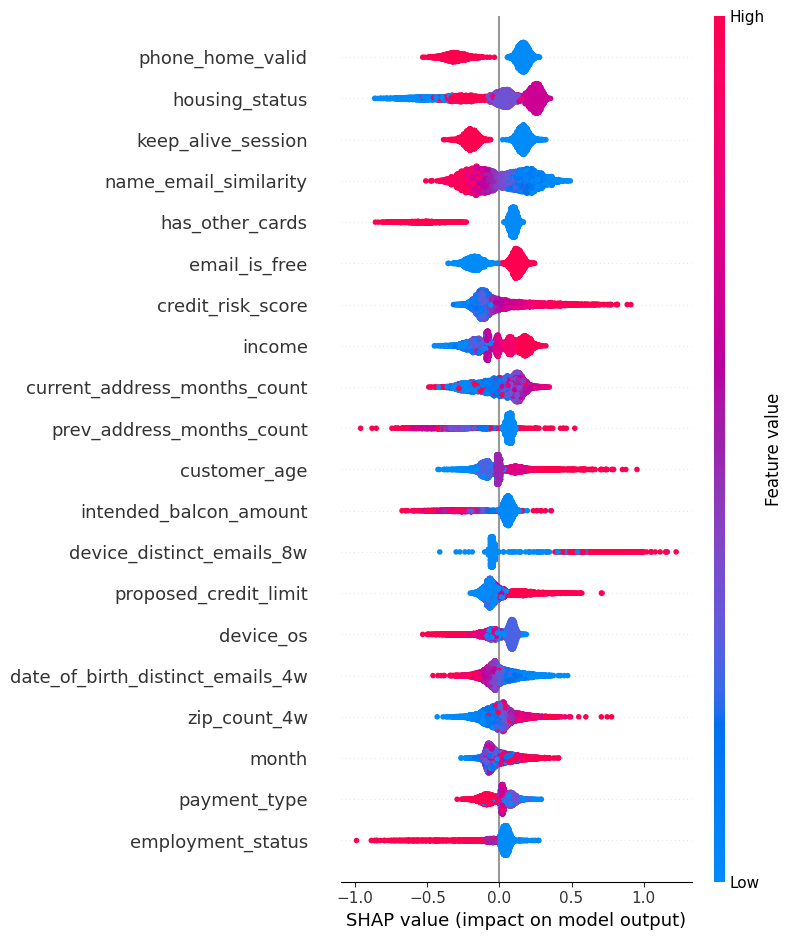

In [94]:
shap.summary_plot(shap_values[1], X_test_all_client, feature_names=columns)

Text(0, 0.5, 'accuracy')

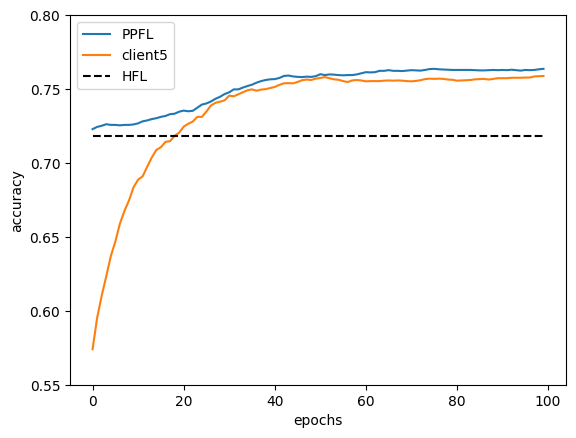

In [60]:
plt.plot(ppfl_skorch.history[:,'valid_acc'], label='PPFL')
plt.plot(client5_skorch.history[:,'valid_acc'], label='client5')
plt.plot([0.717940414507772]*100, linestyle='--',color='k', label='HFL')
plt.legend()
plt.ylim([0.55,0.8])
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [19]:
y_pred_client5 = client5_skorch.predict(torch.Tensor(X_test_under))
y_pred_ppfl = ppfl_skorch.predict(torch.Tensor(X_test_under))
y_proba_client5 = client5_skorch.predict_proba(torch.Tensor(X_test_under))
y_proba_ppfl = ppfl_skorch.predict_proba(torch.Tensor(X_test_under))

In [28]:
print('client5 accuracy: ', accuracy_score(y_test_under, y_pred_client5))
print('ppfl accuracy: ', accuracy_score(y_test_under, y_pred_ppfl))

print('client5 f1: ', f1_score(y_test_under, y_pred_client5))
print('ppfl f1: ', f1_score(y_test_under, y_pred_ppfl))

print('client5 roc_auc_score: ', roc_auc_score(y_test_under, y_proba_client5[:,1]))
print('ppfl roc_auc_score: ', roc_auc_score(y_test_under, y_proba_ppfl[:,1]))

client5 accuracy:  0.7588395285584769
ppfl accuracy:  0.7636748262314899
client5 f1:  0.7579617834394903
ppfl f1:  0.7631738340399757
client5 roc_auc_score:  0.8389285300371772
ppfl roc_auc_score:  0.842778849518073


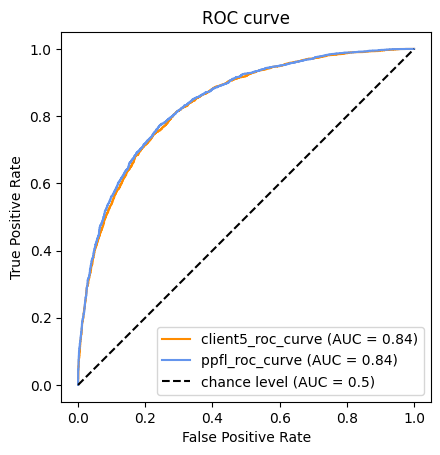

In [35]:
from sklearn.metrics import RocCurveDisplay
ax = plt.gca()

RocCurveDisplay.from_predictions(
    y_test_under, y_proba_client5[:,1], name='client5_roc_curve',color='darkorange', ax=ax
)
RocCurveDisplay.from_predictions(
    y_test_under, y_proba_ppfl[:,1], name='ppfl_roc_curve',color='cornflowerblue',ax = ax
)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()